# Visualising Tree Data

In this notebook, we work with a tabular set of referral data.  Customers who buy a product from a particular company are given a referral code, which they can share with up to five friends.  If one of the friends goes on to buy the product and quotes the referral code, they get a discount.  In turn, this new customer receives their own referal code to share with another five people.  

How can we use our data to best visualise who has referred who?

### Imports

In [159]:
# Import ETE Toolkit for visualising tree-based data
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace, TextFace, add_face_to_node

# Import pandas and numpy for data manipulation and maths
import pandas as pd
import numpy as np

### Inspect tabular data

Let's take a look at the data we have in its current form.

In [160]:
data = pd.read_csv("data.csv", encoding="ISO-8859-1")
data.head(10)

,Date,Name,Referred by,Amount spent (£)
0,18/05/2020,Alice,NaN,4.35
1,18/05/2020,Bob,Alice,28.00
2,18/05/2020,Carol,Bob,3.70
3,19/05/2020,Niaj,Alice,4.50
4,19/05/2020,Mallory,Bob,3.30
5,19/05/2020,Dan,Carol,5.30
6,19/05/2020,Erin,Carol,9.00
7,19/05/2020,Frank,Dan,5.00
8,19/05/2020,Grace,Erin,5.00
9,20/05/2020,Heidi,Frank,3.00


We have the following columns:

- Date—date of the referral
- Name—name of the customer who made a certain purchase
- Referred by—name of whomever referred the customer
- Amount spent (£)—amount spent by a customer in their purchase, in GBP

We can also see that Alice was the first customer out of those in this dataset—the rest of the referrals have come as a result of her initial referrals of Bob and Niaj.

To visualise this data with ETE Toolkit, we need to convert in to *Newick format*.  At first glance it may look like complete gibberish—a mess of parentheses with some commas thrown in for good measure.  But, this is a relatively standard way of compactly describing tree structures in mathematics and science.  Let's explore what kind of trees we can produce.

### ((d,e)b,c)a;

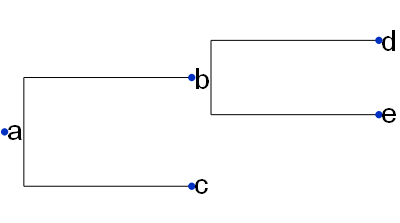

In [161]:
# Specify formatting of tree
ts = TreeStyle()

# Hide leaf labels and scale
ts.show_leaf_name = False
ts.show_scale=False

# Define layout function to label tree nodes
def my_layout(node):
        F = TextFace(node.name, tight_text=True, fsize=12, ftype="Arial")
        add_face_to_node(F, node, column=0, position="branch-right")

# Apply layout function
ts.layout_fn = my_layout

# Add margin between tree branches
ts.branch_vertical_margin = 30


# Create Tree instance
t = Tree("((d,e)b,c)a;", format=1)

# Render inline in notebook
t.render("%%inline", tree_style=ts, w=400)  

### (2,(5,6)3,(7,8)4)1;

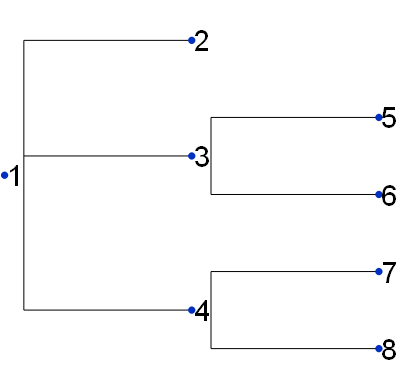

In [162]:
# Create Tree instance
t = Tree("(2,(5,6)3,(7,8)4)1;", format=1)

# Render inline in notebook
t.render("%%inline", tree_style=ts, w=400)  

You may be able to notice that a set of branches is represented by a pair of parentheses.  The number of branches coming off of a given node is determined by the presence of commas within the parentheses.  And of course, pairs of parentheses can be nested to produce more and more complex structures.

Let's convert our data into a Newick tree:

In [163]:
referred = {}

for name in data["Name"]:
    referred[name] = data[data["Referred by"] == name]["Name"].values

newick_tree = "(" + ",".join(referred["Alice"]) + ")" + "Alice"


max_iters = 5
count = 0

while count < max_iters:
    
    temp = list(filter(lambda k: '(' in k, newick_tree.split(")")))

    temp2 = [item.split("(")[-1] for item in temp]

    temp3 = ",".join(temp2)

    temp4 = temp3.split(",")

    for name in temp4:

        if referred[name].any():
            newick_tree = newick_tree.replace(name, "(" + ",".join(referred[name]) + ")" + name)
            
    count += 1

newick_tree = newick_tree + ";"

newick_tree

'(((((Heidi)Frank,Peggy)Dan,(Grace,Judy)Erin)Carol,((Rupert)Ivan)Mallory)Bob,(((Bertha)Trent)Olivia,Sybil)Niaj,(Paul)Arthur,Merlin)Alice;'

Now, let's feed in into ETE and see what we get out the other end!

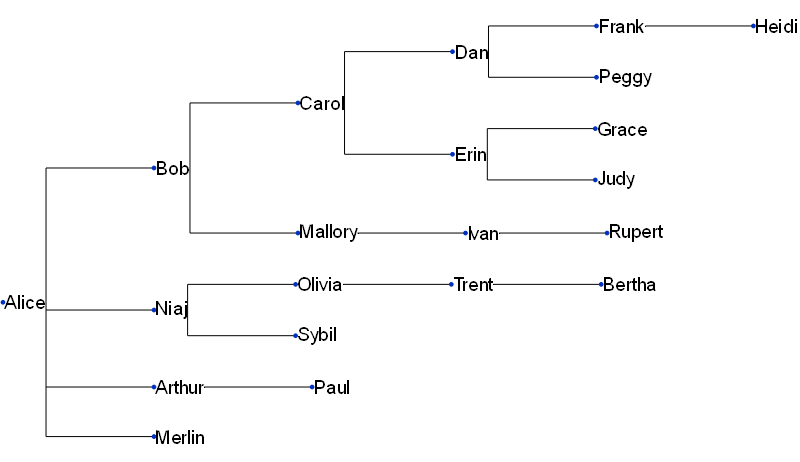

In [164]:
# Create Tree instance
t = Tree(newick_tree, format=1)

# Render inline in notebook
t.render("%%inline", tree_style=ts, w=800)

Not too bad!  Looking quite basic at the moment—but ETE has taken a lot of the complexity out of the visualisation process.  What's more, we can simply re-run our code whenever we get updated data!

Another advantage of ETE is that we can quite easily make adjustments to presentational aspects of the tree.  Let's see if we can make it look a bit snazzier. 

In [165]:
def get_colour(amount_spent):
    """
    Classify a purchase into one of four bins, depending on the amount spent.  Then, assign a corresponding colour
    to the node face.
    """
    
    if 0.0 <= amount_spent < 5.0:
        return "#CD7F32"
    elif 5.0 <= amount_spent < 10.0:
        return "#C0C0C0"
    else:
        return "#FFD700"


# Define a node style to set the size of nodes
nstyle = NodeStyle()
    
nstyle["size"] = 10
    

# Iterate through nodes, setting their styles 
for node in t.iter_descendants("postorder"):
        
    amount_spent = float(data[data["Name"] == node.name]["Amount spent (£)"].values)

    node.img_style["fgcolor"] = get_colour(amount_spent)
    
    node.img_style["size"] = 10

    
# Set style of root node
t.img_style["size"] = 10
t.img_style["fgcolor"] = get_colour(data[data["Name"] == "Alice"]["Amount spent (£)"].values)

In [166]:
# Add legend
ts.legend.add_face(CircleFace(10, "#CD7F32"), column=0)
ts.legend.add_face(TextFace("  £0—£10 spent", fsize=10, ftype="Arial"), column=1)

ts.legend.add_face(CircleFace(10, "#C0C0C0"), column=0)
ts.legend.add_face(TextFace("  £10—£20 spent", fsize=10, ftype="Arial"), column=1)

ts.legend.add_face(CircleFace(10, "#FFD700"), column=0)
ts.legend.add_face(TextFace("  £20+ spent", fsize=10, ftype="Arial"), column=1)

# Position legend in lower right corner
ts.legend_position=4

# Add title
ts.title.add_face(TextFace("Product Referral Scheme", fsize=30, ftype="Arial", fstyle="italic"), 
                  column=0)

# Additional info
ts.title.add_face(TextFace("Total spent by referred customers: £" + str(int(data["Amount spent (£)"].sum())), fsize=20, ftype="Arial", fstyle="italic"), 
                  column=0)

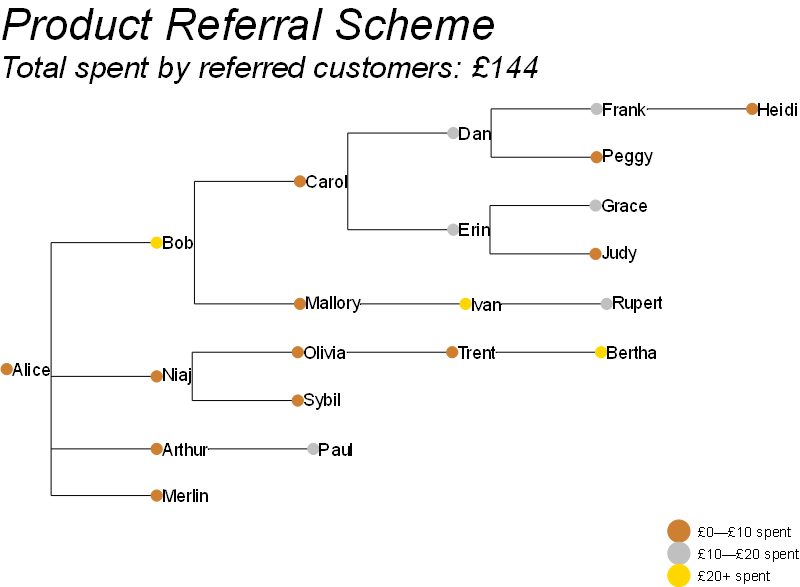

In [167]:
# Render inline in notebook
t.render("%%inline", tree_style=ts, w=800)

That's better.  We're still just scratching the surface of what ETE Toolkit is capable of, but as a quick illustration, this is enough to get some of the key ideas across.

### Conclusion

The human brain loves to hoover up visual information.  Trees have a ready real-world analogy that makes them intuitive and easy to understand.  This makes them a great tool for explaining data to non-specialists.  And to make one final generalisation—the brain has a number of natural strengths and a number of natural weaknesses.  We will always have an easier time digesting data when it is presented to us in a way that works with these peculiarities, rather than against them.  